# Interpolate SSH variables to CTD locations of SS9802 voyage

In [1]:
%run ../../_setup.py

from netCDF4 import Dataset, num2date
from xarray import open_dataset
from OceanPy.netcdf import createNetCDF
from shutil import copyfile

import numpy as np
from scipy.interpolate import griddata

import matplotlib.pyplot as plt



In [2]:
# load ctd data
input_file_ctd = os.path.join(datadir, 'ss9802', 'processed', 'ctd', 'ss9802_ctd.nc')
ctd = Dataset(input_file_ctd, 'r')

# load altimetry data
input_file = os.path.join(datadir, 'external', 'ssh', 'rep', 'rep_allsat_phy_l4_135_-60_160_-45_1998.nc')
ssh = open_dataset(input_file)

## make selection of SSH data and store in netCDF

In [3]:
# select data range
west = 135
south = -53.4
east = 149
north = -47

# west = 137
# south = -52.4
# east = 147
# north = -48.2

# select time
time_voy = slice('1998-03-12', '1998-03-28')
time_sel = slice('1998-01-01', '1998-04-30')

ssh = ssh.sel(longitude=slice(west, east), latitude=slice(south, north), time=time_voy)


In [4]:
# output files
output_file_sel = os.path.join(datadir, 'external', 'ssh', 'processed', 'rep_allsat_phy_l4_%s_%s_%s_%s_199803.nc' 
                               %(west, int(south), east, int(north)))
output_file_ctd = os.path.join(datadir, 'external', 'ssh', 'processed', 'rep_allsat_phy_l4_ss9802_ctd.nc')

In [5]:
if os.path.isfile(output_file_sel):
    print('Output file %s already exists.' %os.path.basename(output_file_sel))
else: 
    ssh.to_netcdf(output_file_sel)
    print('Output file %s saved in: %s.' %(os.path.basename(output_file_sel), os.path.dirname(output_file_sel)))
ssh.close()

Output file rep_allsat_phy_l4_135_-53_149_-47_199803.nc saved in: /home/janjaapmeijer/Checkouts/phd/data/external/ssh/processed.


## interpolate SSH variables to CTD locations

In [6]:
ssh = open_dataset(output_file_sel)

In [7]:
# CTD dimensions
lon_ctd, lat_ctd = ctd['lon'][:, 0], ctd['lat'][:, 0]
time = num2date(ctd['time'][:, 0], ctd['time'].units)
time_str = [t.strftime('%Y-%m-%d') for t in time]

# SSH dimensions
time_str_ssh = np.datetime_as_string(ssh.time, unit='D')

In [8]:
group = 'CTD'

dimensions = {
    'time': time.size,
    'latitude': lat_ctd.size,
    'longitude': lon_ctd.size
}

variables = {'sla': (), 'adt': (), 'ugos': (), 'vgos': (), 'ugosa': (), 'vgosa': ()}
for var in variables:
    variables[var] = variables[var] + (ssh[var].standard_name, 'f8', 'time',)


In [9]:
# interpolate geostrophic and gradient wind velocities to CTD locations
loni, lati = np.meshgrid(ssh.longitude, ssh.latitude)
points = np.array((loni.flatten(), lati.flatten())).T

# for var in data.keys():
new_variables = {}
for var in variables:
    data = np.ma.masked_all((time.size,))
    for i in range(2, data.size):
        values = ssh[var].sel(time=time_str[i]).values.flatten()
        data[i,] = griddata(points, values, (lon_ctd[i], lat_ctd[i]))
    new_variables['/%s/%s' %(group, var)] = variables[var] + (data,)


In [10]:
# calculate direction angle of geostrophic velocity vectors
ugos = new_variables['/%s/%s' %(group, 'ugos')][3]
vgos = new_variables['/%s/%s' %(group, 'vgos')][3]

xpos = ugos.data < 0
ypos = vgos.data < 0
direction = np.arctan(vgos / ugos)
direction[xpos] = np.arctan(vgos[xpos] / ugos[xpos]) + np.pi
direction[xpos & ypos] = np.arctan(vgos[xpos & ypos] / ugos[xpos & ypos]) - np.pi

new_variables['/%s/%s' %(group, 'dir')] = ('sea_water_velocity_to_direction', 'f8', 'time', direction)

## store ssh variables at CTD locations in netCDF

In [11]:
# load file and variables
if output_file_ctd is not None and os.path.isfile(output_file_ctd):
    print('Output file %s already exists.' %os.path.basename(output_file_ctd))
    ssh_ctd = createNetCDF(output_file_ctd)
elif output_file_ctd is not None and not os.path.isfile(output_file_ctd):
    copyfile(output_file_sel, output_file_ctd)
    print('Output file %s, copied from input file %s.'
          %(os.path.basename(output_file_ctd), os.path.basename(output_file_sel)))
    ssh_ctd = createNetCDF(output_file_ctd)


Output file rep_allsat_phy_l4_ss9802_ctd.nc, copied from input file rep_allsat_phy_l4_135_-53_149_-47_199803.nc.


In [12]:
try:
    # create group
    dsgroup = ssh_ctd.dataset.createGroup(group)

    # # create dimensions and coordinates
    for name, size in dimensions.items():

        dsgroup.createDimension(name, size)

        if name in dimensions:
            if name == 'time':
                values = time
            elif name == 'longitude':
                values = np.ma.masked_invalid(lon_ctd)
            elif name == 'latitude':
                values = np.ma.masked_invalid(lat_ctd)
            else:
                values = ctd[name][:]

            new_variables['/%s/%s' %(group, name)] = (name, 'f8', name, values)

    # # create variables
    ssh_ctd.create_vars(new_variables)

    ssh_ctd.close()
    
except IndexError:
    print('oops')

## open SSH variables at CTD locations and plot

In [13]:
ssh_ctd = open_dataset(output_file_ctd, group='CTD')

/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


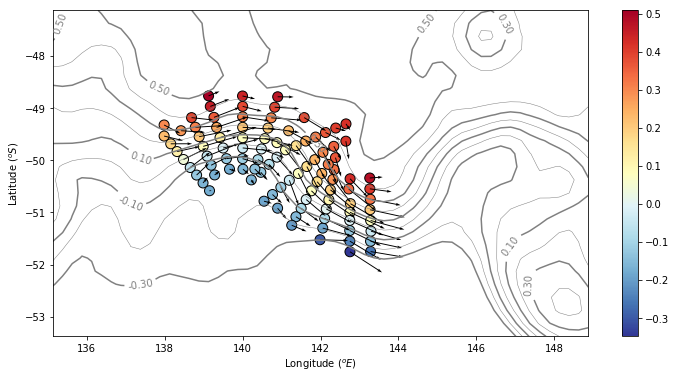

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))

bounds = [-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]

# pcol = ax.contour(ssh.longitude, ssh.latitude, ssh.adt.mean('time'))
ct = ax.contour(ssh.longitude, ssh.latitude, ssh.adt.mean('time'), bounds, 
                     colors='gray', linestyles='solid', linewidths=0.5)

for ib, b in enumerate(bounds):
    if b in bounds[0::2]:
        zc = ct.collections[ib]
        plt.setp(zc, linewidth=1.5)
ax.clabel(ct, bounds[0::2], inline=1, fmt='%.2f')

scat = ax.scatter(ssh_ctd.longitude, ssh_ctd.latitude, 
                  c=ssh_ctd.adt, cmap=plt.cm.RdYlBu_r, s=100, edgecolors='k')

quiv = ax.quiver(ssh_ctd.longitude[2:], ssh_ctd.latitude[2:], ssh_ctd.ugos[2:], ssh_ctd.vgos[2:], 
                 units='inches', scale=1, width=1.1e-3*fig.get_size_inches()[0], color='k')

fig.colorbar(scat, ax=ax)

# plot labels
ax.set_xlabel(r'Longitude ($^oE$)')
ax.set_ylabel(r'Latitude ($^oS$)')
ax.set_title('')

fig.show()